In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import SVG
import os
import pydotplus

import keras
from keras.optimizers import Adam, SGD, rmsprop
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Dropout, Input, Dropout, concatenate
from keras.layers.recurrent import GRU, LSTM
from keras.utils import plot_model
# keras.utils.vis_utils.pydot = pydot
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

Using TensorFlow backend.


In [0]:
data = np.load("drive/My Drive/imputed-normed-ep_1_24.npz", allow_pickle=True)

In [0]:
features_sequence = data['ep_tdata'].astype(np.float32) # 12 time series features
features_static = data['adm_features_all'].astype(np.float32) # 5 non-ts features,the unit of age: day
labels = data["adm_labels_all"][:, 1].astype(np.float32) # 24 hrs mortality

In [0]:
trans = [0]*features_sequence.shape[0]

In [0]:
for i in range(features_sequence.shape[0]):
    trans[i] = features_sequence[i].T

In [0]:
trans= np.array(trans)

In [27]:
trans.shape

(36093, 12, 24)

In [0]:
features_sequence = trans

In [0]:
x_seq_full_train, x_seq_test, x_static_full_train, x_static_test, y_full_train, y_test = train_test_split(
    features_sequence, features_static, labels, test_size = 0.20, random_state = 2020)

x_seq_train, x_seq_val, x_static_train, x_static_val, y_train, y_val = train_test_split(
    x_seq_full_train, x_static_full_train, y_full_train, test_size = 0.20, random_state = 2020)

In [14]:
len(y_val)

5775

In [0]:
def impute_mean(source_data, input_data):
    '''
    Takes the source data, and uses it to determine means for all
    features; it then applies them to the input data.
    
    inputs:
    source_data: a tensor to provide means
    input_data: the data to fill in NA for
    
    output:
    output_data: data with nans imputed for each feature
    
    '''
    
    output_data = input_data.copy()
    
    for feature in range(source_data.shape[1]):
        feature_mean = np.nanmean(source_data[:, feature, :][np.where(source_data[:, feature, :] != 0)])
        ind_output_data = np.where(np.isnan(output_data[:, feature, :]))
        output_data[:, feature, :][ind_output_data] = feature_mean
    return output_data

In [0]:
x_seq_train_original = x_seq_train.copy()
x_seq_train = impute_mean(x_seq_train_original, x_seq_train)
x_seq_val = impute_mean(x_seq_train_original, x_seq_val)
x_seq_test = impute_mean(x_seq_train_original, x_seq_test)

In [46]:
x_seq_train_original.shape

(23099, 12, 24)

In [0]:
from keras.layers import Masking, Activation, Input

In [55]:
# Define inputs
sequence_input = Input(shape = (x_seq_train.shape[1], x_seq_train.shape[2], ), dtype = 'float32', name = 'sequence_input')
static_input = Input(shape = (x_static_train.shape[1], ), name = 'static_input')
# sequence_input = Masking(mask_value=-1, input_shape=(x_seq_train.shape[1], x_seq_train.shape[2], ))(sequence_input)
# model.add(Masking(mask_value=0., input_shape=(timesteps, features)))
# Network architecture
seq_x = GRU(units = 128)(sequence_input)

# Seperate output for the GRU later
seq_aux_output = Dense(1, activation='sigmoid', name='aux_output')(seq_x)

# Merge dual inputs
x = concatenate([seq_x, static_input])

# We stack a deep fully-connected network on the merged inputs
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.10)(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
# Sigmoid output layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

# optimizer
opt = Adam(lr = 0.0001)

# build model
model = Model(inputs = [sequence_input, static_input], outputs = [main_output, seq_aux_output])
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'], loss_weights = [1, 0.2])

# save a plot of the model
#plot_model(model, to_file='experiment_GRU-DO.svg')

# fit the model
history = model.fit([x_seq_train, x_static_train], [y_train, y_train], epochs = 10, batch_size = 64,\
                    validation_data=([x_seq_val, x_static_val], [y_val, y_val]),)

Train on 23099 samples, validate on 5775 samples
Epoch 1/10
23099/23099 [==============================] - 13s 551us/step - loss: 2.6613 - main_output_loss: 2.6494 - aux_output_loss: 0.0565 - main_output_accuracy: 0.9923 - aux_output_accuracy: 0.9894 - val_loss: 0.6330 - val_main_output_loss: 0.6227 - val_aux_output_loss: 0.0249 - val_main_output_accuracy: 0.9964 - val_aux_output_accuracy: 0.9953
Epoch 2/10
23099/23099 [==============================] - 12s 507us/step - loss: 1.5648 - main_output_loss: 1.5597 - aux_output_loss: 0.0241 - main_output_accuracy: 0.9918 - aux_output_accuracy: 0.9952 - val_loss: 0.0957 - val_main_output_loss: 0.0900 - val_aux_output_loss: 0.0244 - val_main_output_accuracy: 0.9964 - val_aux_output_accuracy: 0.9960
Epoch 3/10
23099/23099 [==============================] - 12s 508us/step - loss: 1.1924 - main_output_loss: 1.1875 - aux_output_loss: 0.0235 - main_output_accuracy: 0.9927 - aux_output_accuracy: 0.9963 - val_loss: 0.3284 - val_main_output_loss: 0.32

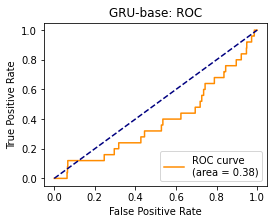

In [59]:
# the difference of pred_main and pred_aux is that pred_main uses both time series data and non-ts data, but pred_aux only uses the time series data to do prediction

pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_main)
auc = roc_auc_score(y_test, pred_main)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU-base')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

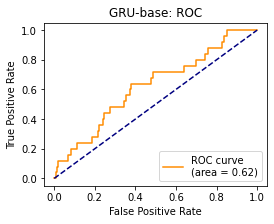

In [60]:
pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_aux)
auc = roc_auc_score(y_test, pred_aux)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU-base')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

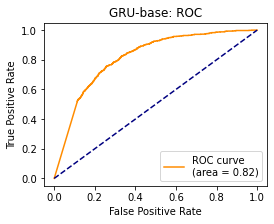

In [20]:
# AUC for the totoal mortality prediction

pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_main)
auc = roc_auc_score(y_test, pred_main)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU-base')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

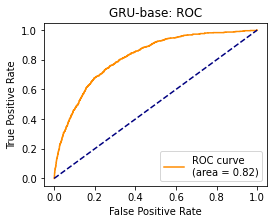

In [21]:
# AUC for the totoal mortality prediction
pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_aux)
auc = roc_auc_score(y_test, pred_aux)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU-base')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

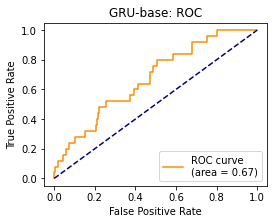

In [168]:
# the best result for 24hrs mortality prediction

pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_aux)
auc = roc_auc_score(y_test, pred_aux)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU-base')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

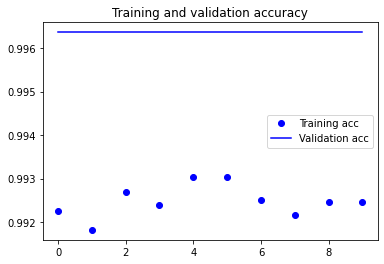

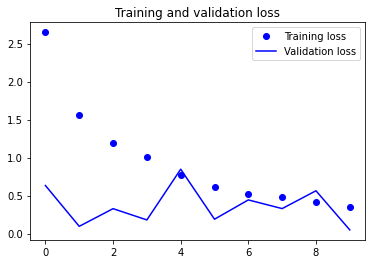

In [58]:
# plot training and validation loss and accuracy

acc = history.history['main_output_accuracy']
val_acc = history.history['val_main_output_accuracy']
loss = history.history['main_output_loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

fig_name = 'loss_svg.svg'
fig.savefig('loss_svg.svg', bbox_inches='tight')